# **Sensor time-series of aircraft engines**
### Can one predict when an engine breaks down?

**1. Introduction**

Can one predict when an engine or device breaks down?

This seems a pure engineering question. But nowadays it is also a data science question. 
More concretely, it is an important question everywhere engines and devices use data to guide maintenance, such as aircraft engines<font color="blue"><sup>1</sup></font>, windturbine engines<font color="blue"><sup>2</sup></font>, and rotating machinery<font color="blue"><sup>3</sup></font>. With regards to human safety and logistic planning, it is not a good idea to just wait until an engine breaks down. It is essential to *proactively* plan maintenance to avoid costly downtime. 

Proactive planning is enabled by *multiple sensor technologies* that provide powerful data about the state of machines and devices. Sensors include data such as temperature, fan and core speed, static pressure etc. Can we use these data to predict within certain margins how long an aircraft engine will be functioning without failure? And if so, how to do it?

This is the question the concept of *remaining useful life (RUL)* attempts to answer. It aims to estimate *the remaining time an item, component, or system is able to function in accordance with its intended purpose before warranting replacement*. The present blog shows how to use deep learning in Python Keras to predict the RUL. It is meant to provide an example case study, not an exhaustive and ultimate solution. 

There is a lack of real data to answer this question. However, data simulations have been made and provide a unique resource. One such a fascinating simulation is provided by the C-MAPSS data<font color="blue"><sup>1</sup></font>. It provides train data that show sensor-based time-series until the timepoint the engine breaks down. In contrast, the test data constitute of sensor-based time-series a "random" time before the endpoint. The key aim is to estimate the RUL of the testset, that is, how much time is left after the last recorded time-point.

**2. Modules**


In [1]:
import os
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import pandas as pd
import numpy as np
np.random.seed(1337)
import requests, zipfile, io
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import scipy.stats
from keras.utils import plot_model

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

d:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

Now that the files are in your home directory, you can read them using Pandas **read_csv**. We will load a train- and testset, as well as a RUL set. RUL contains the true values for remaining useful life to which we are going to compare our predicted values in the testset.

**4. Loading the data**

In [2]:
train = pd.read_csv('train_FD001.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)
test = pd.read_csv('test_FD001.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)
RUL = pd.read_csv('RUL_FD001.txt', parse_dates=False, decimal=".", header=None)

**5. Missing values**

In [3]:
tableNA = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1)
tableNA.columns = ['train', 'test']
#We will first drop the columns that consisted of missing values:
train.drop(train.columns[[-1,-2]], axis=1, inplace=True)
test.drop(test.columns[[-1,-2]], axis=1, inplace=True)

cols = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
train.columns = cols
test.columns = cols

**6. Outliers and flat lines**

In [4]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,20631.000,51.507,29.228,1.000,26.000,52.000,77.000,100.000
cycles,20631.000,108.808,68.881,1.000,52.000,104.000,156.000,362.000
op_setting1,20631.000,-0.000,0.002,-0.009,-0.002,0.000,0.002,0.009
op_setting2,20631.000,0.000,0.000,-0.001,-0.000,0.000,0.000,0.001
op_setting3,20631.000,100.000,0.000,100.000,100.000,100.000,100.000,100.000
s1,20631.000,518.670,0.000,518.670,518.670,518.670,518.670,518.670
s2,20631.000,642.681,0.500,641.210,642.325,642.640,643.000,644.530
s3,20631.000,1590.523,6.131,1571.040,1586.260,1590.100,1594.380,1616.910
s4,20631.000,1408.934,9.001,1382.250,1402.360,1408.040,1414.555,1441.490
s5,20631.000,14.620,0.000,14.620,14.620,14.620,14.620,14.620


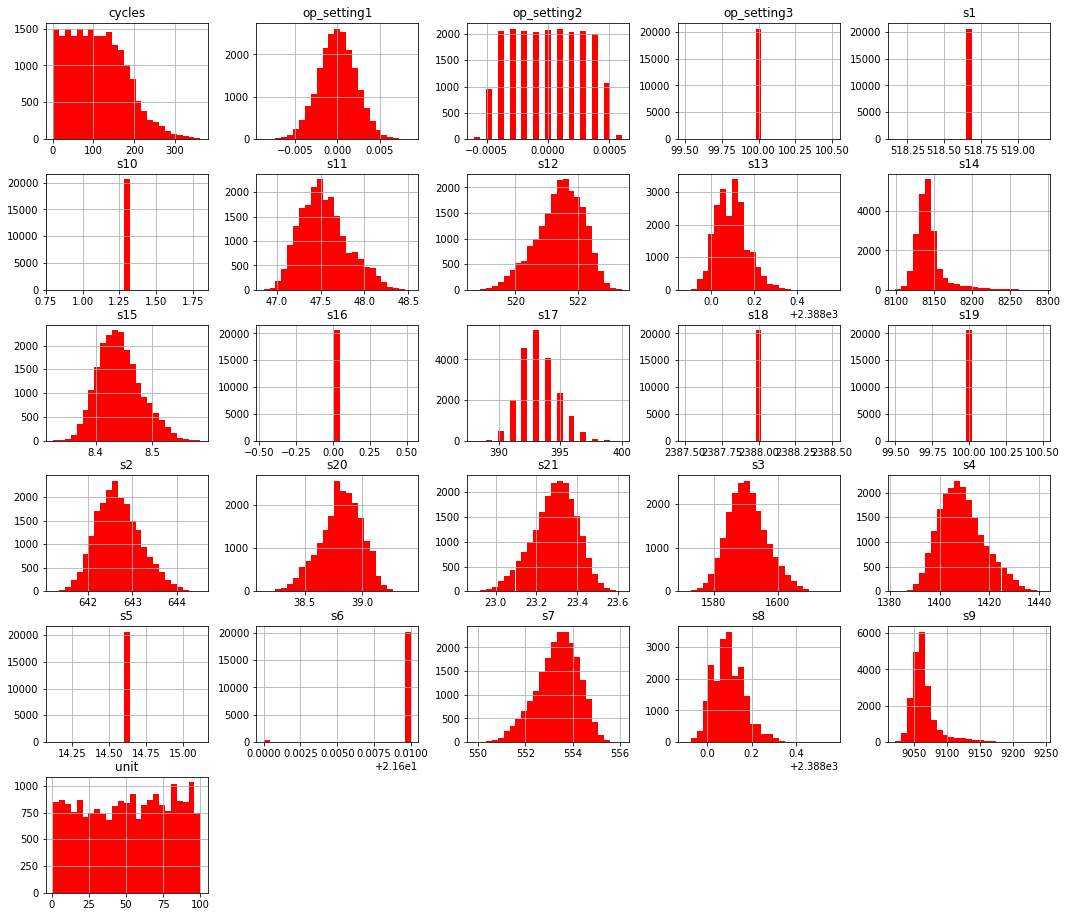

In [5]:
train.hist(bins=25, figsize=(18,16),color='red')
plt.show()

The sensors s1, s5, s10, s16, s18, and s19 as well as op_setting 3, will for this reason be removed from further analyses:

In [6]:
train.drop(['s1', 's5','s6', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)
test.drop(['s1', 's5','s6', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)

The distribution of the columns looks as follows:

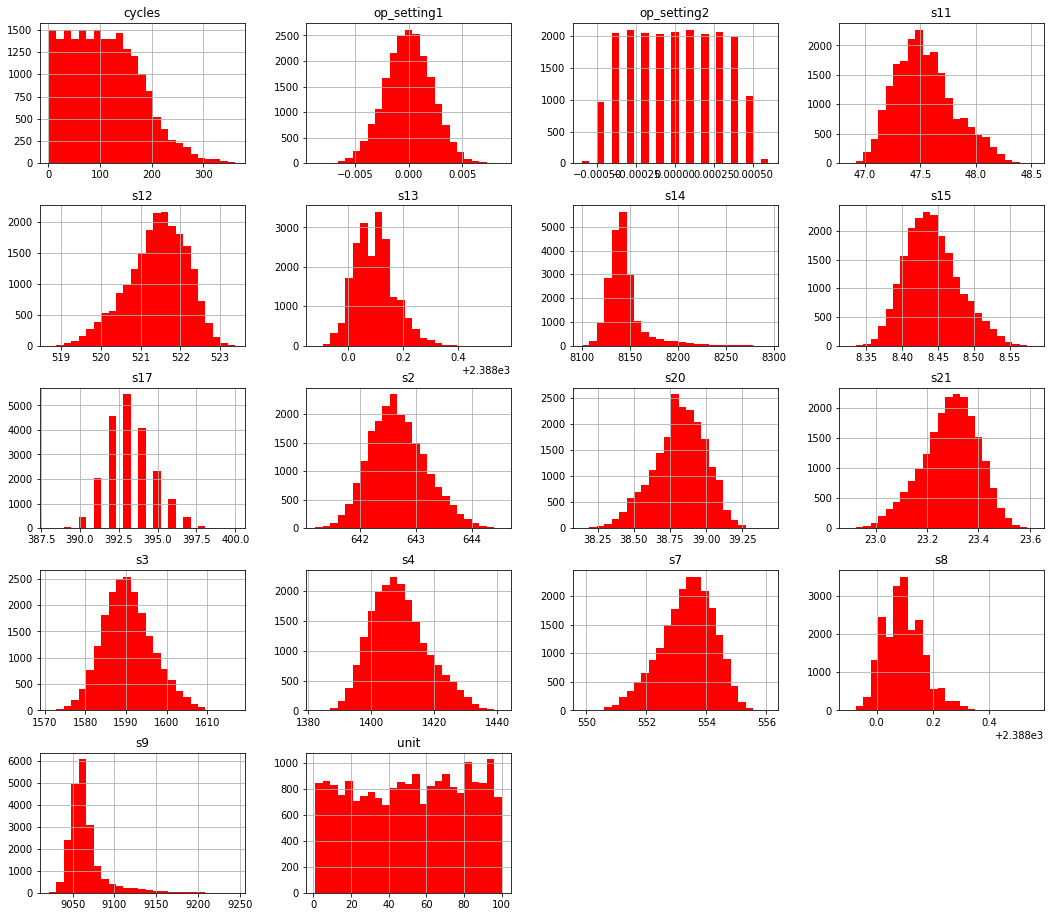

In [7]:
train.hist(bins=25, figsize=(18,16),color='red')
plt.show()

**7. Exploratory analyses of the max. number of cycles per unit**

Exploratory data analyses provide insight into the aircraft engines in action. For example, it would be good to have an idea of the maximum lifetime of the 100 different units. The barplots below show that there is a large variation across units regarding max. number of cycles, and that, as expected, the number of cycles is shorter for testset than trainset.

In [8]:
cyclestrain = train.groupby('unit', as_index=False)['cycles'].max()
cyclestest = test.groupby('unit', as_index=False)['cycles'].max()

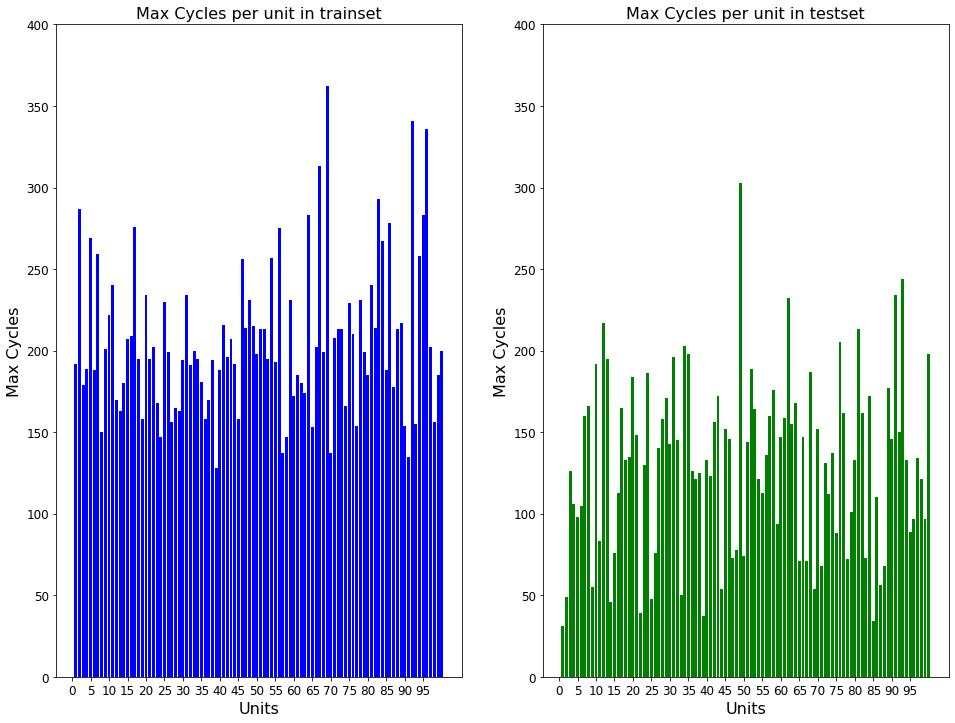

In [9]:
fig = plt.figure(figsize = (16,12))
fig.add_subplot(1,2,1)
bar_labels = list(cyclestrain['unit'])
bars = plt.bar(list(cyclestrain['unit']), cyclestrain['cycles'], color='Blue')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max Cycles', fontsize=16)
plt.title('Max Cycles per unit in trainset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
fig.add_subplot(1,2,2)
bars = plt.bar(list(cyclestest['unit']), cyclestest['cycles'], color='green')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max Cycles', fontsize=16)
plt.title('Max Cycles per unit in testset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**9. Establishing remaining life in cycles**

It is now about time to determine the remaining useful life (RUL) for the trainset, for each row.
First, we determine in the trainset for each row the max. cycles for the particular unit. We use the **groupby** command to obtain for every unit the max. number of cycles, and in turn use **pd.merge** to bring these values into the original train set:

In [10]:
train = pd.merge(train, train.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
train.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
train['TTF'] = train['maxcycles'] - train['cycles']

\begin{equation*}
TTF_i = max(cycles) - cycles_i
\end{equation*}

**10. Scaling**

In [11]:
scaler = MinMaxScaler()
ntrain = train.copy()
ntrain.iloc[:,2:18] = scaler.fit_transform(ntrain.iloc[:,2:18])
ntest = test.copy()
pd.DataFrame(ntest.columns).transpose()
ntest.iloc[:,2:18] = scaler.transform(ntest.iloc[:,2:18])
ntest.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,13096.000,51.544,28.289,1.000,28.000,52.000,76.000,100.000
cycles,13096.000,76.837,53.058,1.000,33.000,69.000,113.000,303.000
op_setting1,13096.000,0.499,0.127,0.029,0.414,0.500,0.586,0.948
op_setting2,13096.000,0.504,0.245,0.000,0.333,0.500,0.750,1.083
s2,13096.000,0.381,0.121,-0.024,0.297,0.377,0.461,0.931
s3,13096.000,0.372,0.109,-0.044,0.296,0.370,0.443,0.796
s4,13096.000,0.380,0.113,0.036,0.299,0.375,0.452,0.863
s7,13096.000,0.629,0.110,0.166,0.557,0.636,0.707,0.965
s8,13096.000,0.259,0.087,-0.015,0.197,0.258,0.318,0.606
s9,13096.000,0.165,0.051,0.013,0.131,0.160,0.190,0.598


**11. Visualize the scaled data**

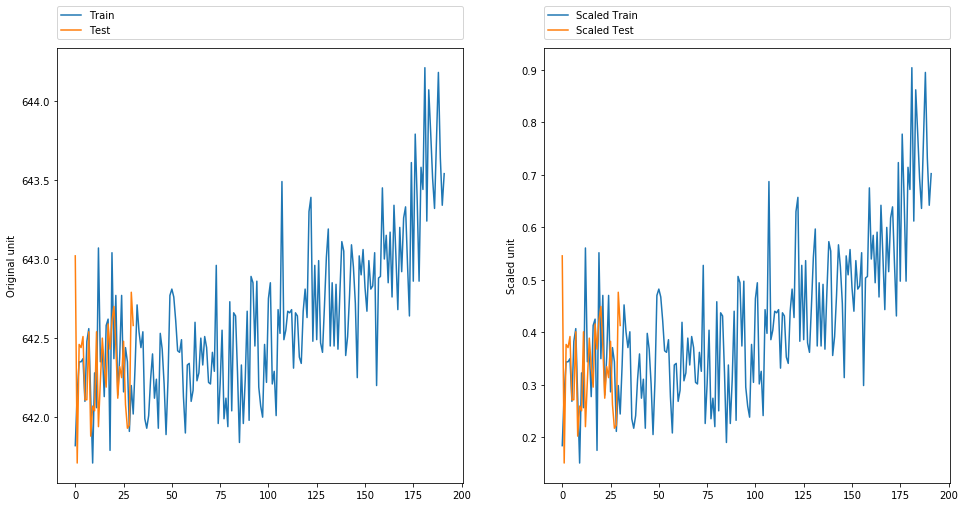

In [12]:
fig = plt.figure(figsize = (16, 8))
fig.add_subplot(1,2,1)
plt.plot(train[train.unit==1].s2)
plt.plot(test[test.unit==1].s2)
plt.legend(['Train','Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Original unit')
fig.add_subplot(1,2,2)
plt.plot(ntrain[ntrain.unit==1].s2)
plt.plot(ntest[ntest.unit==1].s2)
plt.legend(['Scaled Train','Scaled Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

**12. Fraction time to failure**

\begin{equation*}
fTTF_i = \frac{TTF_i - min(TTF)}{max(TTF) - min(TTF)}
\end{equation*}

In [13]:
def fractionTTF(dat,q):
    return(dat.TTF[q]-dat.TTF.min()) / float(dat.TTF.max()-dat.TTF.min())
fTTFz = []
fTTF = []

for i in range(train['unit'].min(),train['unit'].max()+1):
    dat=train[train.unit==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)
ntrain['fTTF'] = fTTF

**13. Neural network in Keras**

In [14]:
X_train = ntrain.values[:,1:18]
Y_train = ntrain.values[:, 20]
X_test = ntest.values[:,1:18]
model = Sequential()
model.add(Dense(16, input_dim=17, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal'))
#model.add(Dropout(rate=0.2))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])
plot_model(model, to_file='model.png')

history = model.fit(X_train, Y_train, validation_split=0.4, epochs=100, batch_size=256, verbose=0)

W0929 15:01:43.781948  5092 deprecation_wrapper.py:119] From d:\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0929 15:01:43.795937  5092 deprecation_wrapper.py:119] From d:\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0929 15:01:43.797922  5092 deprecation_wrapper.py:119] From d:\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0929 15:01:43.826859  5092 deprecation_wrapper.py:119] From d:\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0929 15:01:44.000905  5092 deprecation_wrapper.py:119] From d:\python37\lib\site-packages\keras\backend\tensorflow_backend.py:986: Th

**14. Predict test score, fraction RUL from 1.00-0.00**

In [15]:
score = model.predict(X_test)
print(score.min(), score.max())

0.016961418 1.0470576


In [16]:
test = pd.merge(test, test.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
test.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
test['score'] = score
def totcycles(data):
    return(data['cycles'] / (1-data['score']))
    
test['maxpredcycles'] = totcycles(test)
def RULfunction(data):
    return(data['maxpredcycles'] - data['maxcycles'])

test['RUL'] = RULfunction(test)

\begin{equation*}
max(predicted cycles_i) = \frac{cycles_i}{(1-predicted fTTF_i)}
\end{equation*}

\begin{equation*}
RUL_i = max(predicted cycles_i) - max(cycles)
\end{equation*}

**15. Predict RUL in cycles**

In [17]:
t = test.columns == 'RUL'
ind = [i for i, x in enumerate(t) if x]

predictedRUL = []

for i in range(test.unit.min(), test.unit.max()+1):
    npredictedRUL=test[test.unit==i].iloc[test[test.unit==i].cycles.max()-1,ind]
    predictedRUL.append(npredictedRUL)

xtrueRUL = list(RUL.loc[:,0])
otrueRUL = []

for i in range(0,len(xtrueRUL)):
    otrueRUL = np.concatenate((otrueRUL, list(reversed(np.arange(xtrueRUL[i])))))
    
xpredictedRUL = list(round(x) for x in predictedRUL)
opredictedRUL = []

for i in range(0,len(xpredictedRUL)):
    opredictedRUL = np.concatenate((opredictedRUL, list(reversed(np.arange(float(xpredictedRUL[i]))))))   


## 16. Comparison predicted and true RUL

We can compare the predicted with the true RUL values using the following lineplot. Actually a lineplot is strictly spoken not valid here, since there are no measures inbetween the units. But it is for visualization purposes: the eye catches quickly that the predicted RULs are often a bit higher than the true values.

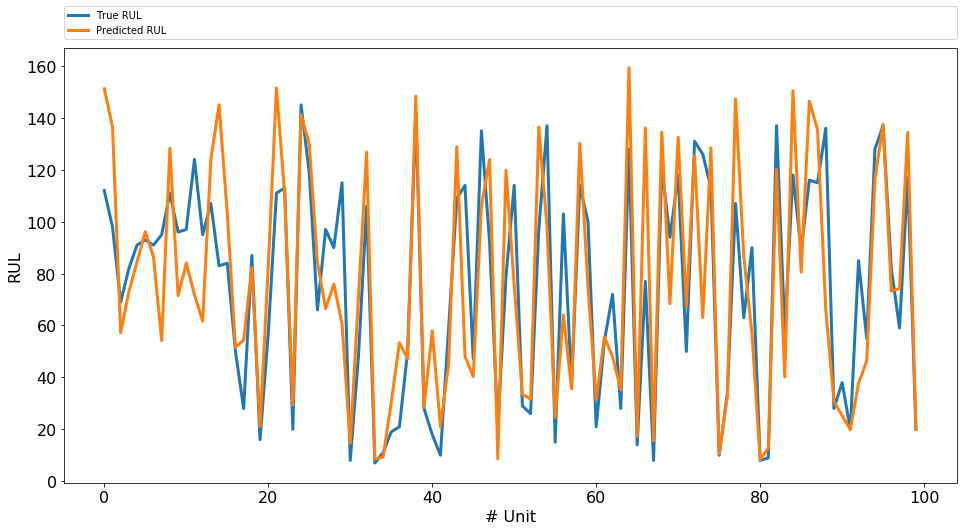

In [18]:
plt.figure(figsize = (16, 8))
plt.plot(RUL,linewidth=3)
plt.plot(predictedRUL,linewidth=3)
plt.xlabel('# Unit', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('RUL', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['True RUL','Predicted RUL'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.show()

Let us inspect the differences in a DataFrame. First we concatenate the true and predicted RUL:

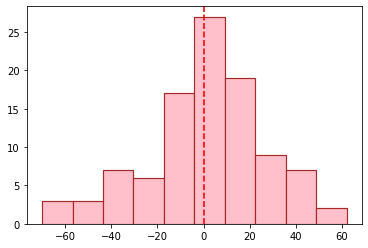

In [19]:
df1 = pd.concat([pd.Series(RUL[0]), pd.Series(xpredictedRUL)], axis=1)
df1.columns = ['true', 'predicted']
df1['diff'] = df1['predicted']-df1['true']

plt.hist(df1['diff'].astype(int), bins=10, color="pink", edgecolor='brown', linewidth=1.2)
plt.axvline(0, color="red", linestyle='dashed', linewidth=1.6)
plt.show()

In [20]:
pd.DataFrame({'Count': [(df1['diff'].astype(int)<0).sum(), (df1['diff'].astype(int)==0).sum(), (df1['diff'].astype(int)>0).sum()]}, columns=['Count'], index=['Smaller', 'Zero', 'Larger'])

,Count
Smaller,42
Zero,4
Larger,54


**17. MSE**

\begin{equation*}
MSE \ RUL = \frac{1}{N} \sum_{i=1}^n (Predicted - True)^2
\end{equation*}

In [21]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(RUL, xpredictedRUL)
print (mse)
print ('Root Mean Squared Error (RMSE): '+ str(np.sqrt(mse)))

670.18
Root Mean Squared Error (RMSE): 25.887834980932645


## Closing words 

So far the results are quite reasonable for a first model in Keras, not denying that a lot can still be improved. Comparing with previous data, the present results are in a MSE range reported by others<font color="blue"><sup>6</sup></font>. 
Several factors can still improve the result:

* Parameter tuning was not used and may give better results
* Cross-validation may control for overfitting
* Features may be improved by for example filtering out the noise
* It should be said that the chosen model may not be the best, other models may take into account the time-related aspects in the data (for example LSTM).

In addition, in a given project the performance metrics (MSE) may not be the main goal, insight into features that explain engine failure may be as important. That goal may be reached using algorithms that can give insight into *feature importance* such as random forest. 

**See you next time!**

Hope you liked this blog. If you have any questions, suggestions, or see any errors, please contact me: <font color="blue">rrighart@googlemail.com</font>.

**Notes & References**

1. A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA

2. Windturbines. https://www.greentechmedia.com/articles/read/big-data-is-boosting-power-production-reducing-downtime-across-wind-fleets

3. A. Qin et al. (2017). Remaining useful life prediction for rotating machinery based on optimal degradation indicator. https://www.hindawi.com/journals/sv/2017/6754968/

5. The name ZigZag should not be confused with the package "ZigZag" that is used to compute peaks in time-series. https://github.com/jbn/ZigZag/blob/master/zigzag_demo.ipynb

6. Jain, Kundu, Kumar Lad (2014). Prediction of remaining useful life of an aircraft engine under unknown initial wear. AIMTDR 2014.

--------------------------------------------------------------------------------------------------------------------------------------------

(c) 2018, R. Righart | Website: https://rrighart.github.io | Email: <font color="blue">rrighart@googlemail.com</font>

Acknowledgements for CSS style go to jckantor